# Trend Following Strategy from Andreas Clenow

This notebook implements the trend following strategy from the book "Following the trend" by Andreas Clenow. This strategy is basically Donchian breakouts plus MA trend filter, so it is very similar to the original turtle strategy in the book "Way of the Turtle" by Curtis Faith.

* Trend Filter: MA50>MA100, long only; MA50<MA100, short only.
* Entry rule:
    1. Close > recent 50 days max price, open long
    1. Close < recent 50 days min price, open short
* Exit rule:
    1. Close <= recent 25 days min price, close long. If the close price drops below the minimum of recent 25 days price, close long positions.
    1. Close >= recent 25 days max price, close short. If the close price rises above the maximum of recent 25 days price, close short positions.
* Trailing Stop: 3 ATR<sub>100</sub>.
* Position sizing: 
    1. Allocate 0.2% cash to each asset, i.e., risk factor is 0.002.
    1. contract_number =$\dfrac{0.002 \times cash}{ATR_{100} \times price}$

In [1]:
%matplotlib inline

from typing import List, Tuple

import backtrader as bt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import ta
from matplotlib import pyplot as plt
from utils import CryptoPandasData

## 1. Reading Data

In [2]:
BAR_SIZE = 3600000 # 30 minute
TIME_BAR_DIR = f'/data/bars/TimeBar/{BAR_SIZE}'

In [3]:
from utils import read_bars as read_bars_tmp

def read_bars(csv_file: str)->pd.DataFrame:
    TIME_BEGIN = pd.to_datetime('2020-06-07T00:00:00.000Z')
    TIME_END = pd.to_datetime('2020-07-30T00:00:00.000Z')
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp'] < TIME_END)]
    return bars_df

In [4]:
time_bars = read_bars(f'/data/bars/TimeBar/{BAR_SIZE}/TimeBar.{BAR_SIZE}.Binance.Swap.BTC_USDT.csv')

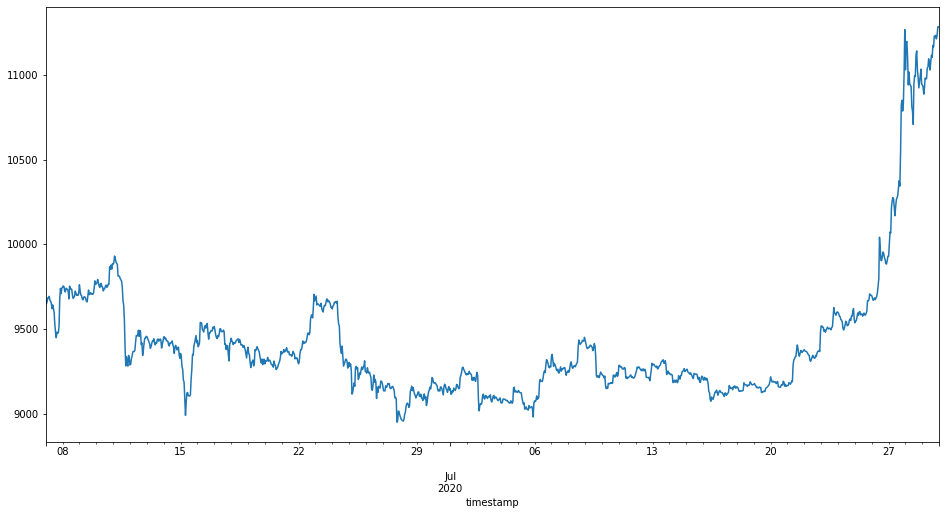

In [5]:
time_bars['vwap'].plot(figsize=(16, 8))

In [6]:
from utils import CryptoPandasData

data_feed = CryptoPandasData(dataname=time_bars, timeframe=bt.TimeFrame.Minutes, compression=60, name='Binance-Swap-BTC_USDT')

**They look almost the same!! There must be some cointegration.**

## 2. The Strategy

In [7]:
class DonchianChannelsIndicator(bt.Indicator):
    '''Donchian channel.'''

    alias = ('DCH', 'DonchianChannel',)

    lines = ('mid', 'high', 'low',)  # dc middle, dc high, dc low

    params = (
        ('period', 20), # lookback period
    )

    plotinfo = dict(subplot=False)  # plot along with data
    plotlines = dict(
        mid=dict(ls='--'),  # dashed line
        high=dict(_samecolor=True),  # use same color as prev line (mid)
        low=dict(_samecolor=True),  # use same color as prev line (high)
    )

    def __init__(self):
        hi, lo = self.data.high(-1), self.data.low(-1) # start from previous bar, current bar not considered
        self.l.high = bt.indicators.Highest(hi, period=self.p.period)
        self.l.low = bt.indicators.Lowest(lo, period=self.p.period)
        self.l.mid = (self.l.high + self.l.low) / 2.0  # avg of the above

In [8]:
class ClenowTrendFollowingStrategy(bt.Strategy):
    """The trend following strategy from the book "Following the trend" by Andreas Clenow."""
    alias = ('ClenowTrendFollowing',)

    params = (
        ('trend_filter_fast_period', 50),
        ('trend_filter_slow_period', 100),
        ('fast_donchian_channel_period', 25),
        ('slow_donchian_channel_period', 50),
        ('trailing_stop_atr_period', 100),
        ('trailing_stop_atr_count', 3),
        ('risk_factor', 0.002)
    )

    def __init__(self):
        self.trend_filter_fast = bt.indicators.EMA(period=self.params.trend_filter_fast_period)
        self.trend_filter_slow = bt.indicators.EMA(period=self.params.trend_filter_slow_period)
        self.dc_fast = DonchianChannelsIndicator(period=self.params.fast_donchian_channel_period)
        self.dc_slow = DonchianChannelsIndicator(period=self.params.slow_donchian_channel_period)
        self.atr = bt.indicators.ATR(period=self.params.trailing_stop_atr_period)
        self.order = None  # the pending order
        # For trailing stop loss
        self.sl_order = None # trailing stop order
        self.sl_price = None
        self.max_price = None # track the highest price after opening long positions
        self.min_price = None # track the lowest price after opening short positions

    def stop(self):
        assert self.position.size == 0 # make sure all positions are closed at the end

    def next(self):
        if len(self.data) == (self.data.buflen()-1):
            # send a market order at the last second bar to close all positions
            if self.position.size:
                print(f'Close {self.position.size} at the endd')
                self.close() # close all positions at the end
            return

        # self.dc_slow.low <= self.dc_fast.low <= self.dc_fast.high <= self.dc_slow.high
        assert self.dc_slow.low <= self.dc_fast.low
        assert self.dc_fast.low <= self.dc_fast.high
        assert self.dc_fast.high <= self.dc_slow.high

        if not self.position: # Entry rules
            assert self.position.size == 0
            
            # Position size rule
            max_loss = self.broker.get_cash() * self.p.risk_factor # cash you afford to loss
            position_size = max_loss / self.atr[0]

            if self.data.close > self.dc_slow.high:
                if self.trend_filter_fast > self.trend_filter_slow: # trend filter
                    if self.order:
                        self.broker.cancel(self.order)
                    else:
                        # Entry rule 1
                        self.order = self.buy(price=self.data.close[0], size=position_size, exectype=bt.Order.Limit) 
                        self.max_price = self.data.close[0]
            elif self.data.close < self.dc_slow.low:
                if self.trend_filter_fast  < self.trend_filter_slow: # trend filter
                    if self.order:
                        self.broker.cancel(self.order)
                    else:
                        # Entry rule 2
                        self.order = self.sell(price=self.data.close[0], size=position_size, exectype=bt.Order.Limit) 
                        self.min_price = self.data.close[0]
        else:
            assert self.position.size
            assert self.order is None

            # Exit rules
            if self.position.size > 0:
                # Exit rule 1
                if self.data.close < self.dc_fast.low:
                    self.order = self.order_target_value(target=0.0, exectype=bt.Order.Limit, price=self.data.close[0])
                    return
            else:
                # Exit rule 2
                if self.data.close > self.dc_fast.high:
                    self.order = self.order_target_value(target=0.0, exectype=bt.Order.Limit, price=self.data.close[0])
                    return

            # Trailing stop loss
            trail_amount = self.atr[0] * self.p.trailing_stop_atr_count
            if self.position.size > 0:
                self.max_price = max(self.max_price, self.data.close[0])
                if self.sl_price is None or self.sl_price < self.max_price - trail_amount:
                    self.sl_price = self.max_price - trail_amount # increase trailing price
                    if self.sl_order:
                        self.broker.cancel(self.sl_order)
                    else:
                        self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop, price=self.sl_price)
            elif self.position.size < 0:
                self.min_price = min(self.min_price, self.data.close[0])
                if self.sl_price is None or self.sl_price > self.min_price + trail_amount:
                    self.sl_price = self.min_price + trail_amount # decrease trailing price
                    if self.sl_order:
                        self.broker.cancel(self.sl_order)
                    else:
                        self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop, price=self.sl_price)

    def notify_order(self, order):
        if order.status in [order.Created, order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # print logs here

        # Write down: no pending order
        if order.exectype == bt.Order.Stop:
            self.sl_order = None
        else:
            self.order = None

## 3. Running the strategy

In [9]:
LEVERAGE = 1 # No leverage in backtesting
BINANCE_SWAP_TAKER_FEE = 0.0004
INITIAL_CASH = 20000.0 # dollars

In [10]:
from utils import CryptoSpotCommissionInfo, CryptoContractCommissionInfo

def strategy_demo(data_feed: bt.feeds.PandasData):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(ClenowTrendFollowingStrategy)
    cerebro.adddata(data_feed)

    cerebro.broker.setcash(INITIAL_CASH)
    # https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/
    cerebro.broker.set_shortcash(False)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.broker.addcommissioninfo(CryptoContractCommissionInfo(commission=BINANCE_SWAP_TAKER_FEE, mult=LEVERAGE))

    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.Days, compression=1, tann=365)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed, _name='buyandhold')

    results = cerebro.run()
    assert len(results) == 1

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('PnL: %.2f' % (results[0].analyzers.ta.get_analysis().pnl.net.total,))
    print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
    print('CAGR: %.2f%%' % (results[0].analyzers.returns.get_analysis()['ravg'] * 100,))
    print('Total return: %.2f%%' % (list(results[0].analyzers.timereturn.get_analysis().values())[0] * 100,))
    print('Max Drawdown: %.2f%%' % results[0].analyzers.drawdown.get_analysis().max.drawdown)
    print('Buy and Hold: {0:.2f}%'.format(list(results[0].analyzers.buyandhold.get_analysis().values())[0] * 100))

    plt.rcParams['figure.figsize'] = (16, 8)
    cerebro.plot(iplot=False)

    return results[0]

Starting Portfolio Value: 20000.00
Final Portfolio Value: 20251.13
PnL: 251.13
Sharpe Ratio:  0.4635612037376864
CAGR: 0.02%
Total return: 1.26%
Max Drawdown: 4.79%
Buy and Hold: 16.77%


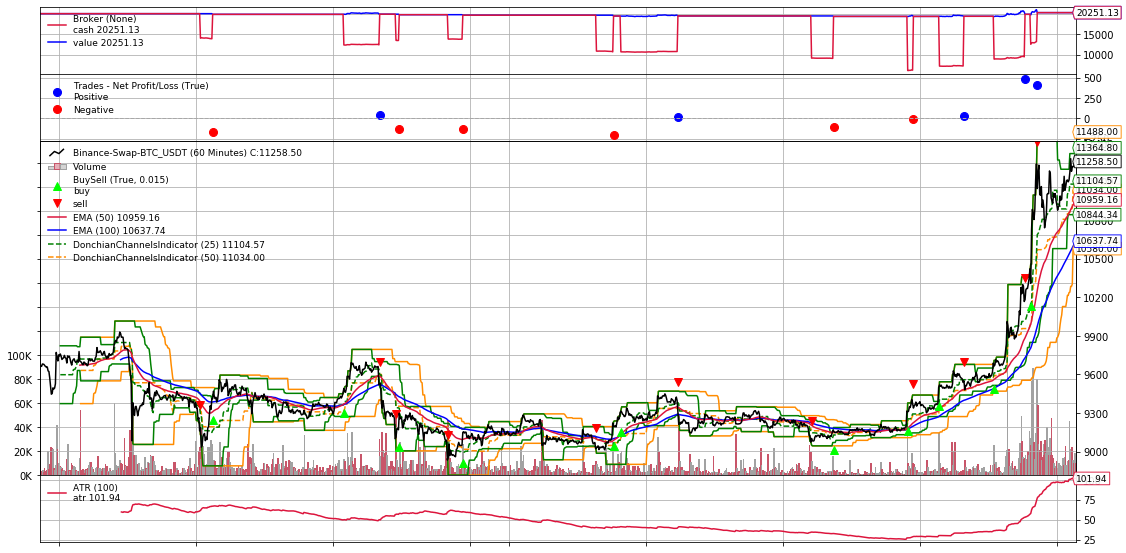

In [11]:
result = strategy_demo(data_feed)

**This strategy doesn't beat the Buy&Hold benchmark, next step we're going to optimize its parameters.**

## References

* [Orders - Backtrader](https://www.backtrader.com/docu/order/)
* [Trading Cryptocurrency Fractional Sizes in backtrader](https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/)
* [Shorting the cash - Backtrader](https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/)
* [Commission Schemes - Backtrader](https://www.backtrader.com/docu/commission-schemes/commission-schemes/)
* [Difference between leverage and multi - Backtrader Community](https://community.backtrader.com/topic/729/difference-between-leverage-and-multi)
* [Forex trading leverage settings in backtrader - Backtrader Community](https://community.backtrader.com/topic/1309/forex-trading-leverage-settings-in-backtrader)
* [How to initialize bt.analyzers.SharpeRatio? - Backtrader Community](https://community.backtrader.com/topic/2747/how-to-initialize-bt-analyzers-sharperatio)